In [1]:
import os
import numpy as np
import shutil
from PIL import Image
from tqdm import tqdm
import warnings
from matplotlib import pyplot as plt
import cv2
import imutils
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [19]:
#ONLY RUN THIS ONCE, this moves the downloaded data and reallocates it into training, testing and validation folders
IMG_PATH = os.path.join(os.getcwd(), "Dataset/")
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        print(IMG_NUM)
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                if not os.path.exists(os.path.join(IMG_PATH, 'TEST\\' + CLASS + '\\')):
                    os.makedirs(os.path.join(IMG_PATH, 'TEST\\' + CLASS + '\\'))
                shutil.copy(img, os.path.join(IMG_PATH, 'TEST\\' + CLASS + '\\'))
            elif n < 0.8*IMG_NUM:
                if not os.path.exists(os.path.join(IMG_PATH, 'TRAIN\\' + CLASS + '\\')):
                    os.makedirs(os.path.join(IMG_PATH, 'TRAIN\\' + CLASS + '\\'))
                shutil.copy(img, os.path.join(IMG_PATH, 'TRAIN\\' + CLASS + '\\'))
            else:
                if not os.path.exists(os.path.join(IMG_PATH, 'VAL\\' + CLASS + '\\')):
                    os.makedirs(os.path.join(IMG_PATH, 'VAL\\' + CLASS + '\\'))
                shutil.copy(img, os.path.join(IMG_PATH, 'VAL\\' + CLASS + '\\'))

98
155


In [2]:
Dataset = os.path.join(os.getcwd(), "Dataset\\")
train_path = os.path.join(Dataset, 'TRAIN')
val_path = os.path.join(Dataset, 'VAL')
test_path = os.path.join (Dataset, 'TEST')
#loads the images and their labels based on the folder
def load_img_data(path):
    dic = {'no': 0, 'yes': 1}
    X = []
    y = []
    for label, Class in enumerate(os.listdir(path)):
        class_path = os.path.join(path,Class) 
        for file in tqdm(os.listdir(class_path)):
            x = cv2.imread(class_path + "\\"+ file)
            X.append(x)
            y.append(label)
    y = np.array(y)
    return X, y
#training, validation and testing data
train_X, train_y = load_img_data(train_path)
val_X, val_y = load_img_data(val_path)
test_X, test_y = load_img_data(test_path)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 100.22it/s]


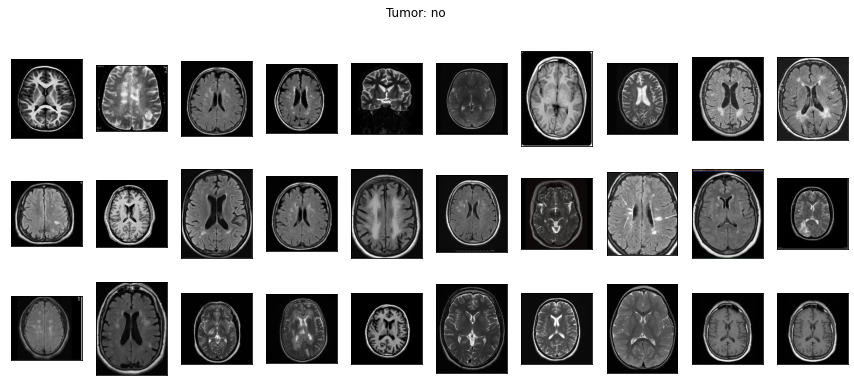

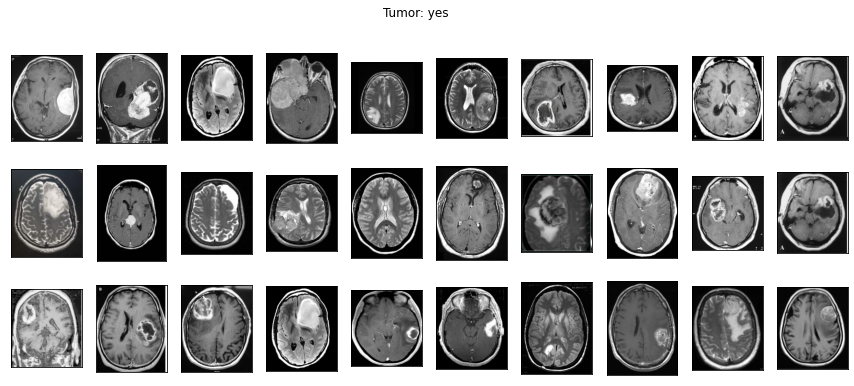

In [21]:
#This segment was is to visualize the different brain scans present
labels_dict = {0: 'no', 1: 'yes'}
num_of_labels = 2
num_of_pics = 30
for index in range(num_of_labels):
    l = np.nonzero(train_y==index)
    imgs = []
    for k in range(num_of_pics):
        imgs.append(train_X[l[0][k]])
    j = 10
    i = int(num_of_pics/j)
    plt.figure(figsize=(15,6))
    c=1
    for img in imgs:
        plt.subplot(i,j,c)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        c+=1
    plt.suptitle('Tumor: {}'.format(labels_dict[index]))
    

In [84]:
def crop_imgs(imgs, image_padding = 0):
    #crops the brain out of the image
    cropped_imgs = []
    for img in imgs:
        #Convert image to grayscale and remove noise
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5,5),0)

        #Applies binary threshold, and applies an opening
        thresh = cv2.threshold(gray,45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations = 2)
        thresh = cv2.dilate(thresh, None, iterations = 2)

        #Finds the Contour line of the modified image
        cnts = cv2.findContours(thresh, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        #Takes the most extreme points of the contour line
        extLeft = tuple(c[c[:,:,0].argmin()][0])
        extRight = tuple(c[c[:,:,0].argmax()][0])
        extTop = tuple(c[c[:,:,1].argmin()][0])
        extBot = tuple(c[c[:,:,1].argmax()][0])

        #Adds padding if necessary, 
        #rewrites a new cropped image based on extreme points of contour
        new_img = img[extTop[1]-image_padding:
                      extBot[1]+image_padding, 
                      extLeft[0]-image_padding: 
                      extRight[0]+image_padding].copy()
        cropped_imgs.append(new_img)
    return cropped_imgs

def save_images(dataset, path, label):
    #Takes dataset and saves it to a new path with class-labelled folder
    if not os.path.exists(path):
        os.makedirs(path)
    if not os.path.exists(os.path.join(path, "NO\\")):
        os.makedirs(os.path.join(path, "NO\\"))
    if not os.path.exists(os.path.join(path, "YES\\")):
        os.makedirs(os.path.join(path, "YES\\"))
    for i, img in enumerate(dataset):
        filename = ''
        if label[i] == 0:
            filename = 'NO\\'+str(i)+'.jpeg'
        else:
            filename = 'YES\\' + str(i) + '.jpeg'
        cv2.imwrite(os.path.join(path,filename), img)
def processing(dataset):
    #Takes dataset and resizes images before applying keras VGG16 pre-processing
    processed = []
    for img in dataset:
        img = cv2.resize(img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
        processed.append(preprocess_input(img))
    return np.array(processed)

In [79]:
#cropped image datasets
train_X_cropped = crop_imgs(train_X)
val_X_cropped = crop_imgs(val_X)
test_X_cropped = crop_imgs(test_X)

In [11]:
#new folder paths
train_cropped_path = os.path.join(Dataset, 'TRAIN_CROPPED\\')
val_cropped_path = os.path.join(Dataset, 'VAL_CROPPED\\')
test_cropped_path = os.path.join(Dataset, 'TEST_CROPPED\\')

In [5]:
#saving cropped images to new folders
save_images(train_X_cropped, train_cropped_path, train_y)
save_images(val_X_cropped, val_cropped_path, val_y)
save_images(test_X_cropped, test_cropped_path, test_y)

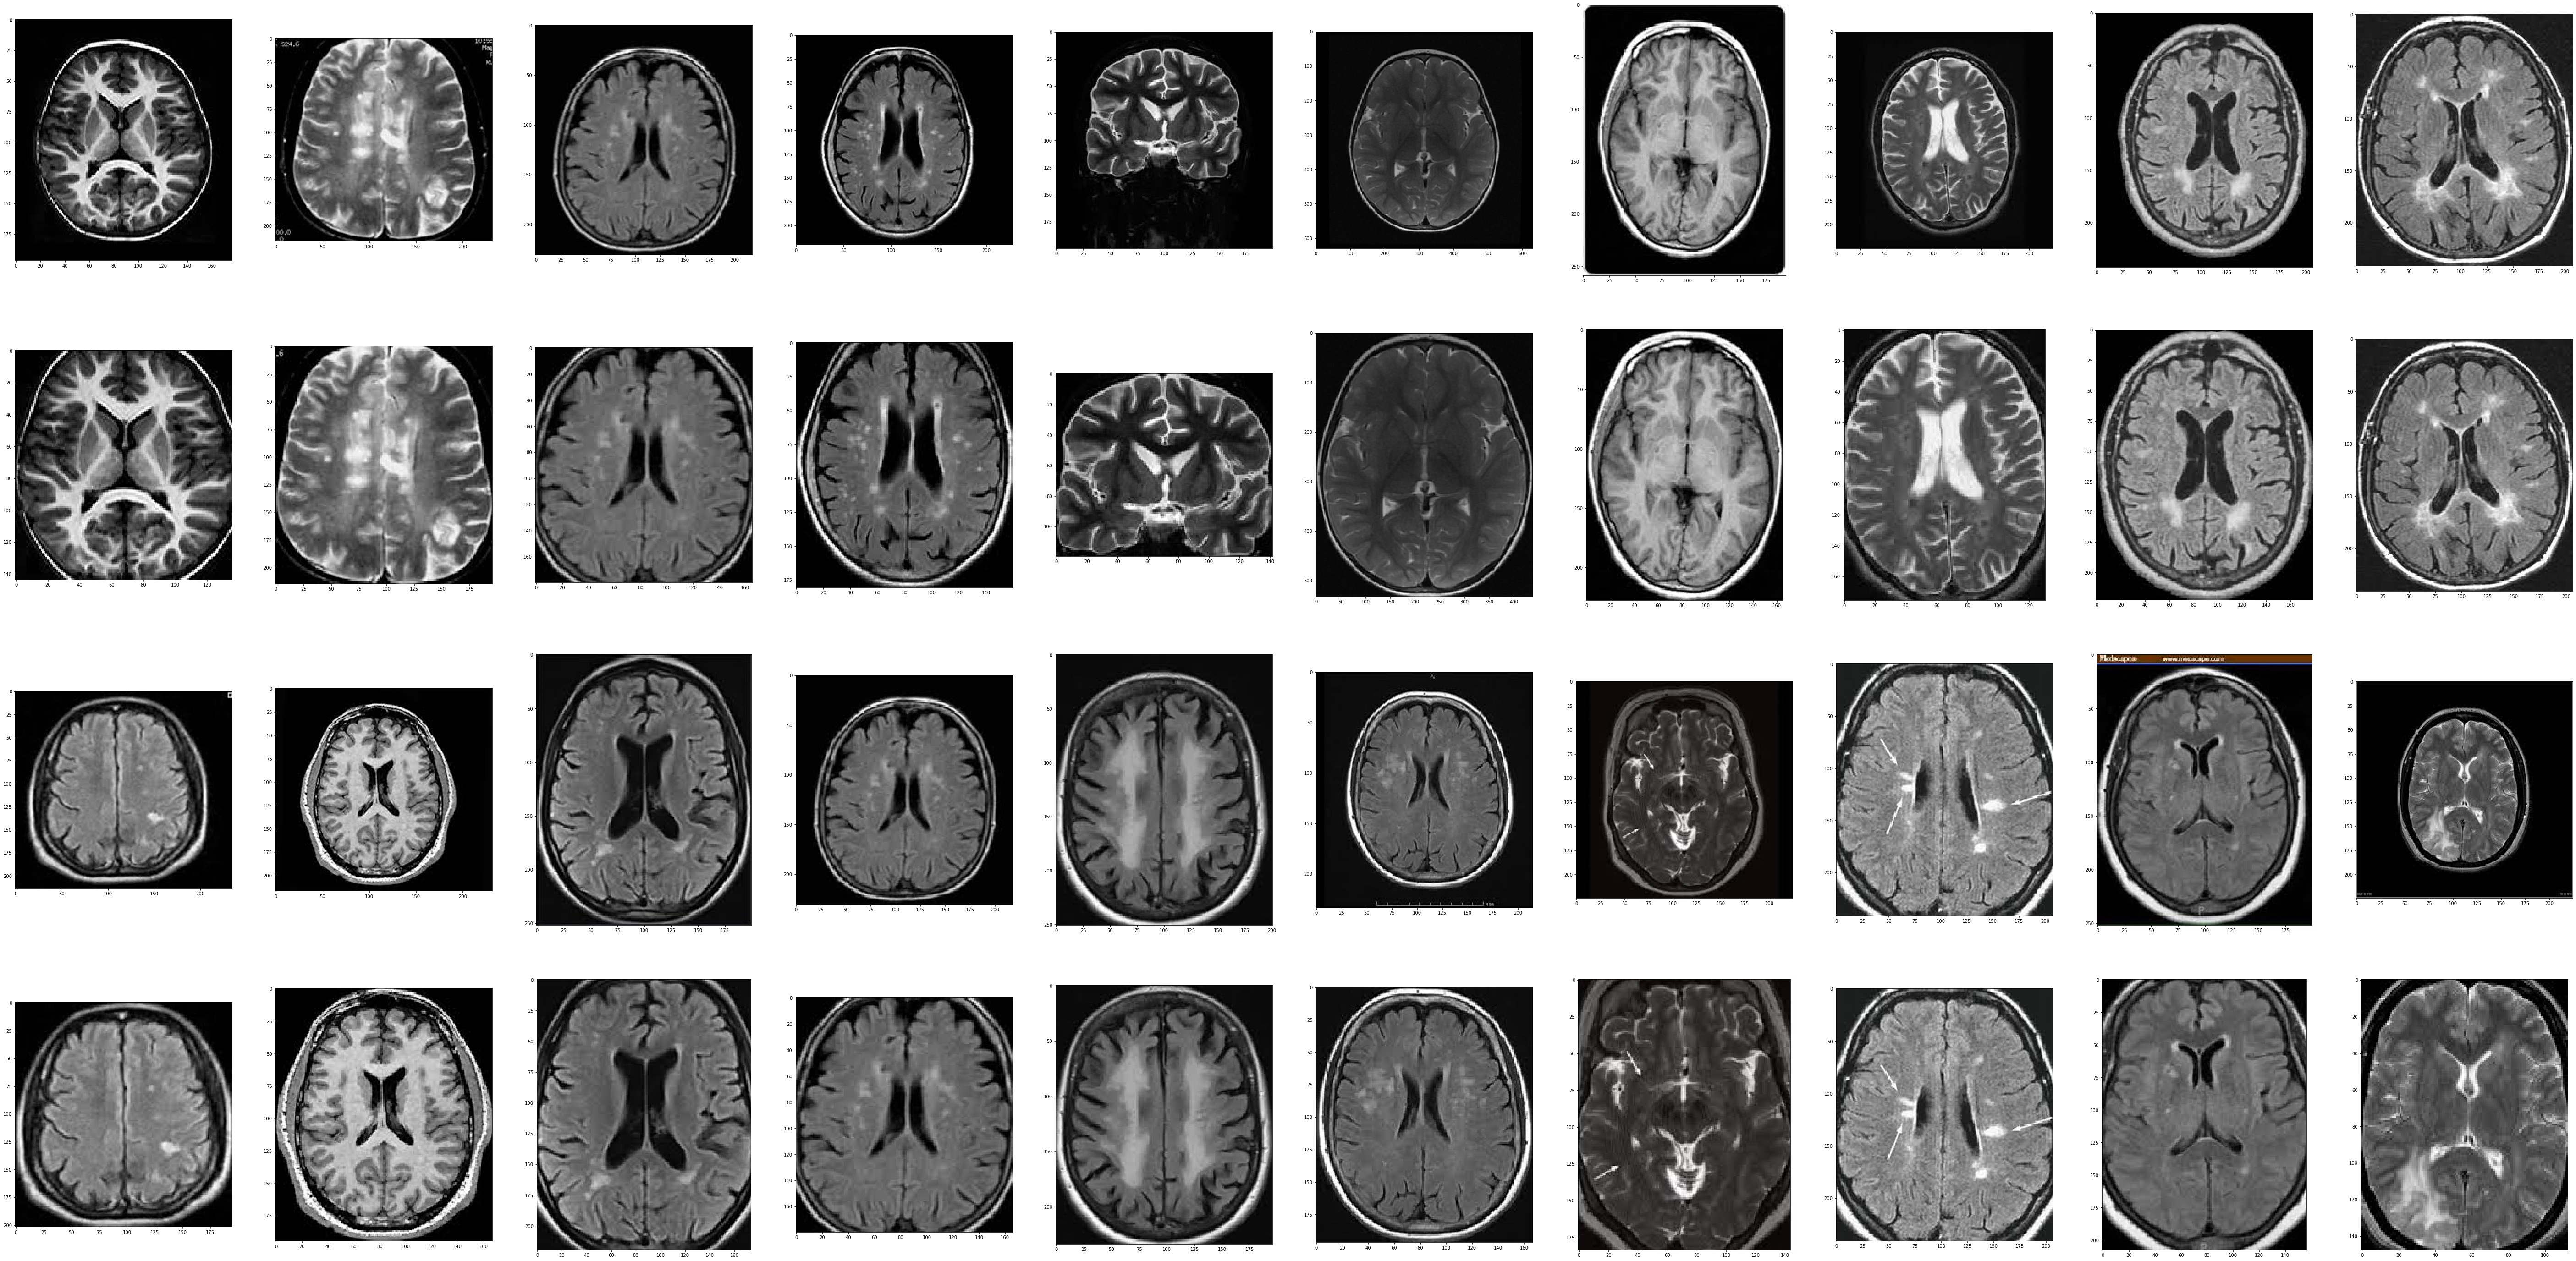

In [26]:
#plotting before and after cropped pics
#cropped pics are directly below their original counterparts
fig = plt.figure(figsize=(100, 50))  # width, height in inches
for i in range(20):
    k = 20*(i//10)+i%10+1
    sub = fig.add_subplot(4, 10, k)
    sub.imshow(train_X[i], interpolation='nearest')
    sub = fig.add_subplot(4,10, k+10)
    sub.imshow(train_X_cropped[i], interpolation = 'nearest')


In [85]:
test_X_cropped = processing(test_X_cropped)
train_augmented_path = os.path.join(Dataset, 'TRAIN_AUGMENTED\\')

In [69]:
#Makes a new directory for augmented images that have undergone vgg16 preprocessing
os.makedirs(train_augmented_path)
os.makedirs(os.path.join(train_augmented_path, "NO\\"))
os.makedirs(os.path.join(train_augmented_path, "YES\\"))

C:\Users\Becca\Documents\Nick_Workspace\Brain Tumour Detection\Dataset\TRAIN_AUGMENTED\


In [51]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
augmented_train_X = train_datagen.flow_from_directory(
    train_cropped_path,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32 ,
    save_to_dir = train_augmented_path,
    save_prefix = "",
    save_format = "jpeg",
    seed = 123
)
augmented_val_X = val_datagen.flow_from_directory(
    val_cropped_path,
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 16,
    seed = 123)
base_model = VGG16(
    include_top = False,
    #Add the file location of the vgg16 weights
    weights = '...keras\\models\\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
    input_shape = (224, 224, 3)
    )

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation = 'sigmoid'))
model.add(layers.Dense(1000, activation = 'sigmoid'))
model.add(layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Found 203 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              4097000   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1001      
Total params: 121,577,233
Trainable par

In [28]:
epoch = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)
history = model.fit(
    augmented_train_X,
    steps_per_epoch = 203//32,
    epochs = epoch,
    validation_data = augmented_val_X,
    validation_steps =50//16,
    callbacks = [es])

Epoch 1/20
6/6 [==============================] - 21s 4s/step - loss: 0.5205 - accuracy: 0.7391 - val_loss: 0.3629 - val_accuracy: 0.8750
Epoch 2/20
6/6 [==============================] - 21s 4s/step - loss: 0.4933 - accuracy: 0.7702 - val_loss: 0.2966 - val_accuracy: 0.8542
Epoch 3/20
6/6 [==============================] - 21s 4s/step - loss: 0.5037 - accuracy: 0.7329 - val_loss: 0.2896 - val_accuracy: 0.8542
Epoch 4/20
6/6 [==============================] - 21s 4s/step - loss: 0.4222 - accuracy: 0.7826 - val_loss: 0.3871 - val_accuracy: 0.8125
Epoch 5/20
6/6 [==============================] - 21s 4s/step - loss: 0.4958 - accuracy: 0.7640 - val_loss: 0.2865 - val_accuracy: 0.8125
Epoch 6/20
6/6 [==============================] - 21s 4s/step - loss: 0.4263 - accuracy: 0.8323 - val_loss: 0.2514 - val_accuracy: 0.8542
Epoch 7/20
6/6 [==============================] - 21s 4s/step - loss: 0.4279 - accuracy: 0.7391 - val_loss: 0.3114 - val_accuracy: 0.8333
Epoch 8/20
6/6 [==================

In [ ]:
# plot model performance
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(epoch_count, train_acc, label = 'Training Set')
plt.plot(epoch_count, val_acc, label = 'Validation Set')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epoch_count, train_loss, label = 'Training Set')
plt.plot(epoch_count, val_loss, label = 'Validation Set')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

Test loss: 0.16743727028369904
Test accuracy: 0.9166666865348816


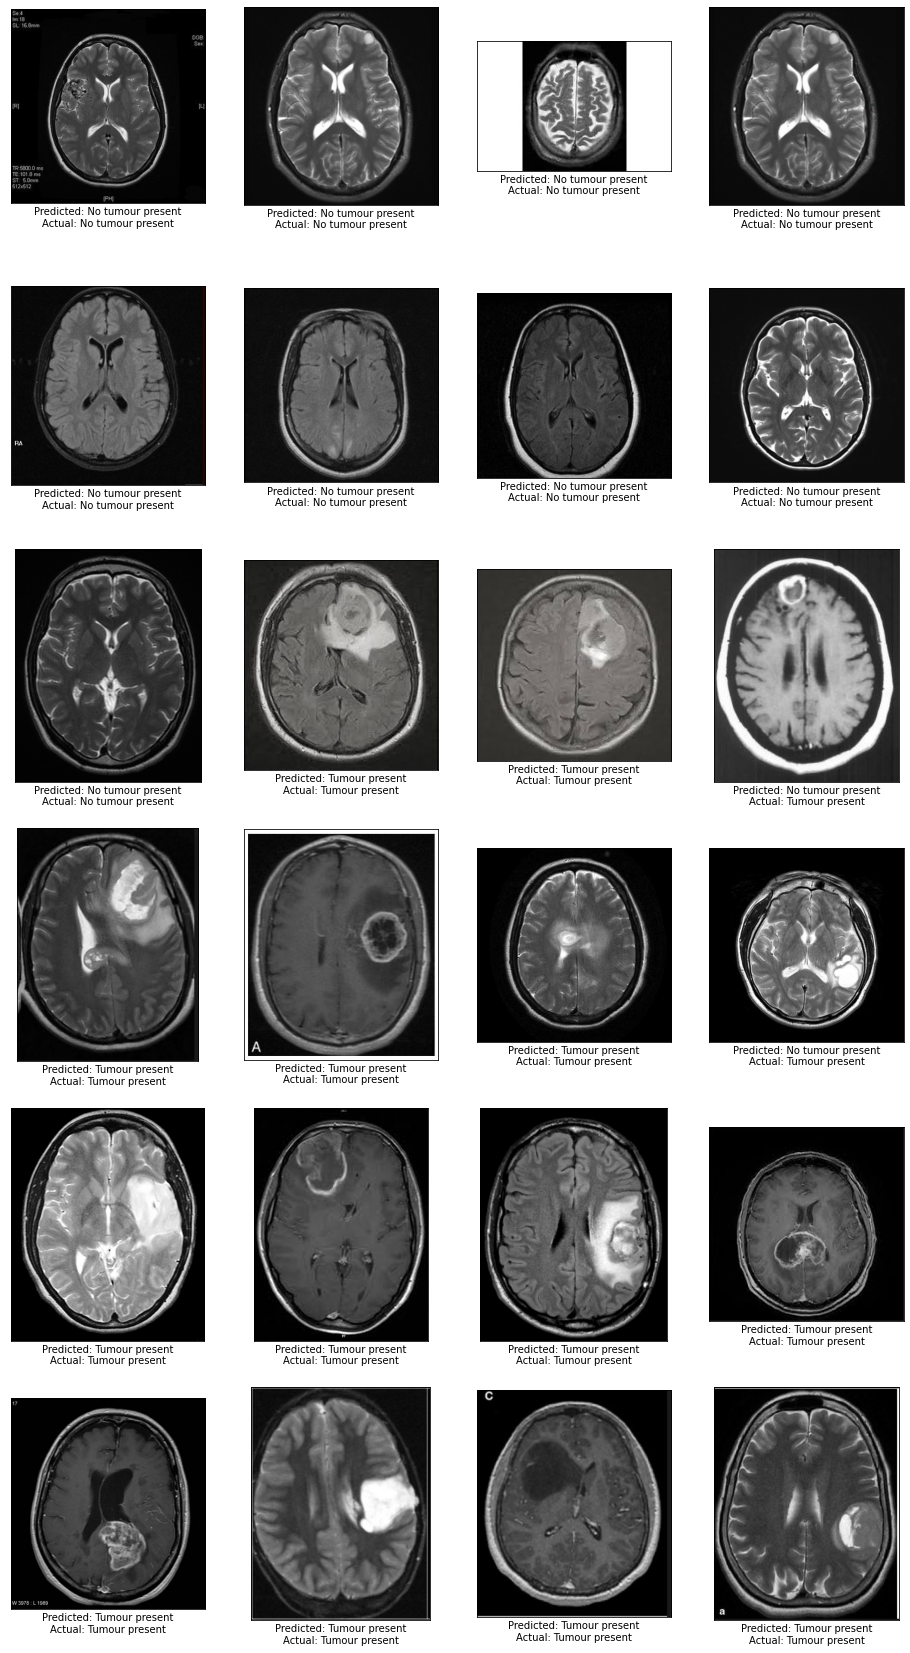

In [88]:
score = model.evaluate(test_X_cropped, test_y, verbose = 0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

y_label = []
for i in test_y:
    if i == 0:
        y_label.append("No tumour present")
    else:
        y_label.append("Tumour present")
y_predict = model.predict(test_X_cropped)
fig = plt.figure (figsize = (16, 30))
for i, img in enumerate(test_X):
    if y_predict[i]>=0.5:
        sub = fig.add_subplot(6, 4, i+1, xlabel = str("Predicted: Tumour present" + "\n" + "Actual: " + y_label[i]))

    else:
        sub = fig.add_subplot(6, 4, i+1, xlabel = str("Predicted: No tumour present" + "\n" + "Actual: " + y_label[i]))
    plt.xticks([])
    plt.yticks([])
    sub.imshow(img)
    
